## Visualize WoFCast Predictions

In [1]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
from scipy.ndimage import maximum_filter

from wofscast.model import WoFSCastModel
from wofscast.border_mask import BORDER_MASK_NUMPY

from wofscast.data_generator import (load_chunk, 
                                     WRFZarrFileProcessor,
                                     WoFSDataProcessor, 
                                     dataset_to_input,
                                     add_local_solar_time
                                    )
from wofscast import checkpoint
from wofscast.wofscast_task_config import (DBZ_TASK_CONFIG, 
                                           WOFS_TASK_CONFIG, 
                                           DBZ_TASK_CONFIG_1HR,
                                           DBZ_TASK_CONFIG_FULL
                                          )



## Predict with WoFS-Cast

In [2]:
# For plotting. 
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from wofscast.plot import WoFSColors, WoFSLevels
from datetime import datetime
import pandas as pd

def to_datetimes(path, n_times = 13):  
    name, freq, ens_mem = os.path.basename(path).split('__')
    start_time_dt = datetime.strptime(name.split('_to')[0], 'wrfwof_%Y-%m-%d_%H%M%S')
    start_time = pd.Timestamp(start_time_dt)
    
    dt_list = pd.date_range(start=start_time, periods=n_times, freq=freq)
    return dt_list[2:]

display_name_mapper = {'U' : 'U-wind Comp.', 
          'V' : 'V-wind Comp.', 
          'W' : 'Vert. Velocity',
          'T' : 'Pot. Temp.', 
          'GEOPOT' : 'Geopot. Height',
          'QVAPOR' : 'QVAPOR', 
          'T2' : '2-m Temp.', 
          'COMPOSITE_REFL_10CM' : 'Comp. Refl.',
          'UP_HELI_MAX' : '2-5 km UH', 
          'RAIN_AMOUNT' : 'Rain Rate',
          'WMAX' : 'Vert. Velocity',
         }

units_mapper = {'T': 'K', 
                'QVAPOR': 'kg/kg', 
                'T2': 'K', 
                'U': 'm/s', 
                'V': 'm/s', 
                'W': 'm/s', 
                'GEOPOT': 'm', 
                'RAIN_AMOUNT': 'in', 
                'COMPOSITE_REFL_10CM': 'dBZ',
                'WMAX': 'm/s',
               }

residual = False
    


In [3]:
base_path = '/work/mflora/wofs-cast-data/datasets_2hr_zarr/2021'
name = 'wrfwof_2021-05-15_000000_to_2021-05-15_021000__10min__ens_mem_09.zarr' ###
path = os.path.join(base_path, name)
    
dataset = load_chunk([path], 1, add_local_solar_time)
dataset = dataset.compute() 


In [4]:
def gradient_nd(arr, axis=0, spacing=3000.):
    """
    Compute the gradient of an N-dimensional array along a specified axis using central difference.
    
    Parameters:
    arr (N-dimensional array): Input array to compute the gradient for.
    axis (int): The axis along which to compute the gradient.
    spacing (float or N-dimensional array): Spacing between points along the specified axis. Can be a single float for uniform spacing or an array of the same shape as arr for non-uniform spacing.
    
    Returns:
    grad (N-dimensional array): Gradient along the specified axis.
    """
    arr = np.asarray(arr)
    grad = np.zeros_like(arr)
    
    # If spacing is a single float, convert it to an array of uniform spacing
    if np.isscalar(spacing):
        spacing = np.full_like(arr, spacing, dtype=float)
    else:
        spacing = np.asarray(spacing, dtype=float)
        if spacing.shape != arr.shape:
            raise ValueError("The shape of spacing must match the shape of the input array")
    
    # Central differences in the interior
    slicing1 = [slice(None)] * arr.ndim
    slicing2 = [slice(None)] * arr.ndim
    slicing3 = [slice(None)] * arr.ndim
    slicing4 = [slice(None)] * arr.ndim
    slicing1[axis] = slice(1, -1)
    slicing2[axis] = slice(2, None)
    slicing3[axis] = slice(None, -2)
    slicing4[axis] = slice(1, -1)
    
    grad[tuple(slicing1)] = (arr[tuple(slicing2)] - arr[tuple(slicing3)]) / (spacing[tuple(slicing2)] + spacing[tuple(slicing3)]) / 2
    
    # Forward differences at the first boundary
    slicing1[axis] = 0
    slicing2[axis] = 1
    grad[tuple(slicing1)] = (arr[tuple(slicing2)] - arr[tuple(slicing1)]) / spacing[tuple(slicing1)]
    
    # Backward differences at the last boundary
    slicing1[axis] = -1
    slicing2[axis] = -2
    grad[tuple(slicing1)] = (arr[tuple(slicing1)] - arr[tuple(slicing2)]) / spacing[tuple(slicing1)]
    
    return grad



In [5]:
%%time 

MODEL_PATH = '/work/cpotvin/WOFSCAST/model/wofscast_test_v178.npz'
norm_stats_path = '/work/mflora/wofs-cast-data/full_normalization_stats'
model = WoFSCastModel(norm_stats_path = norm_stats_path)
model.load_model(MODEL_PATH)

inputs, targets, forcings = dataset_to_input(dataset, model.task_config, 
                                        target_lead_times=slice('10min', '120min'), 
                                        batch_over_time=False, n_target_steps=12)

predictions = model.predict(inputs, targets, forcings)
predictions['WMAX'] = predictions['W'].max(dim='level')
inputs['WMAX'] = inputs['W'].max(dim='level')
targets['WMAX'] = targets['W'].max(dim='level')

for n, dataset in enumerate([predictions, inputs, targets]):
    if n==0:
        dudx = gradient_nd(dataset['U'].values, axis=4)
        dvdy = gradient_nd(dataset['V'].values, axis=3)
        dz = gradient_nd(dataset['GEOPOT'].values, axis=2, spacing=1.0) / 9.8
        dwdz = gradient_nd(dataset['W'].values, axis=2, spacing=dz)
        w = dataset['W'].values
        #dudx = np.gradient(dataset['U'].values, 3000, axis=4)
        #dvdy = np.gradient(dataset['V'].values, 3000, axis=3)
        #dz = (dataset['GEOPOT'].values[:,:,1:,:,:]/9.8 - dataset['GEOPOT'].values[:,:,0:-1,:,:]/9.8)
        #dwdz = (dataset['W'].values[:,:,1:,:,:] - dataset['W'].values[:,:,0:-1,:,:]) / dz
        #w = 0.5*(dataset['W'].values[:,:,1:,:,:] + dataset['W'].values[:,:,0:-1,:,:])
    else:
        dudx = gradient_nd(dataset['U'].values, axis=3)
        dvdy = gradient_nd(dataset['V'].values, axis=2)
        dz = gradient_nd(dataset['GEOPOT'].values, axis=4, spacing=1.0) / 9.8
        dwdz = gradient_nd(dataset['W'].values, axis=4, spacing=dz)
        w = dataset['W'].values
        #dudx = np.gradient(dataset['U'].values, 3000, axis=3)
        #dvdy = np.gradient(dataset['V'].values, 3000, axis=2)
        #dz = (dataset['GEOPOT'].values[:,:,:,:,1:]/9.8 - dataset['GEOPOT'].values[:,:,:,:,0:-1]/9.8)
        #dwdz = (dataset['W'].values[:,:,:,:,1:] - dataset['W'].values[:,:,:,:,0:-1]) / dz
        #w = 0.5*(dataset['W'].values[:,:,:,:,1:] + dataset['W'].values[:,:,:,:,0:-1])
    print (dudx.shape, dvdy.shape, dwdz.shape, w.shape)
    print (dataset['U'].shape, dataset['V'].shape, dataset['W'].shape)
    dataset['DIV'] = xr.DataArray(np.empty(dudx.shape), dims=dataset['T'].dims, coords=dataset['T'].coords)
    dataset['DIV'].values = dudx + dvdy
    
    numer = np.fabs(dudx + dvdy + dwdz - w/10000.)
    denom = np.fabs(dudx) + np.fabs(dvdy) + np.fabs(dwdz-w/10000.)
    norm_cont_residual = numer / denom
    print (numer.mean(), denom.mean(), norm_cont_residual.mean())
    dataset['RESID'] = xr.DataArray(np.empty(dudx.shape), dims=dataset['T'].dims, coords=dataset['T'].coords)
    dataset['RESID'].values = norm_cont_residual
    
    T = dataset['T'].values
    qv = dataset['QVAPOR'].values
    Tv = T*(1+0.61*qv)
    if n==0:
        Tv_bar = np.mean(Tv, axis=(4,3))[:, :, :, np.newaxis, np.newaxis]
        mask = np.ones_like(Tv_bar, dtype=bool)
        mask[:, :, 4:, :, :] = False  
        Tv_bar = np.where(mask, Tv_bar, np.nan)
    else:
        Tv_bar = np.mean(Tv, axis=(3,2))[:, :, np.newaxis, np.newaxis, :]
        mask = np.ones_like(Tv_bar, dtype=bool)
        mask[:, :, :, :, 4:] = False  
        Tv_bar = np.where(mask, Tv_bar, np.nan)
    Tv_pert = Tv - Tv_bar
    B = 9.806*(Tv_pert-Tv)/Tv
    dataset['BUOY'] = xr.DataArray(np.empty(T.shape), dims=dataset['T'].dims, coords=dataset['T'].coords)
    dataset['BUOY'].values = Tv_pert#B

(1, 12, 17, 150, 150) (1, 12, 17, 150, 150) (1, 12, 17, 150, 150) (1, 12, 17, 150, 150)
(1, 12, 17, 150, 150) (1, 12, 17, 150, 150) (1, 12, 17, 150, 150)
0.000116187 0.00029096773 0.46931362
(1, 2, 150, 150, 17) (1, 2, 150, 150, 17) (1, 2, 150, 150, 17) (1, 2, 150, 150, 17)
(1, 2, 150, 150, 17) (1, 2, 150, 150, 17) (1, 2, 150, 150, 17)
0.00011712859 0.0003184322 0.43656245
(1, 12, 150, 150, 17) (1, 12, 150, 150, 17) (1, 12, 150, 150, 17) (1, 12, 150, 150, 17)
(1, 12, 150, 150, 17) (1, 12, 150, 150, 17) (1, 12, 150, 150, 17)
0.00013049059 0.00034843065 0.4467575
CPU times: user 38.4 s, sys: 18.4 s, total: 56.8 s
Wall time: 8.18 s


In [6]:
# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

class WoFSCastAnimator:
    def __init__(self, domain_size, plot_border=False, dts=None):
        self.dts = dts  # Placeholder, replace with your datetime conversion function
        self.plot_border = plot_border
        self.domain_size = domain_size
    
    def __call__(self, segments, var_list, levels, inputs, predictions, targets):
        self.segments = segments
        self.var_list = var_list
        self.var = var_list[0]
        self.levels = levels
        self.cmaps = []
        self.clvls = []
        
        init_ds, pred, tars = self.drop_batch_dim(inputs, predictions, targets)
        
        self.inputs = init_ds
        self.predictions = pred
        self.targets = tars
        
        level_txt = ''
        if levels == 'all': 
            level_txt = f', levels=all'
    
        self.titles = [[f'WoFS REFLCOMP', f'WoFSCast REFLCOMP'], [f'WoFS {display_name_mapper.get(var_list[0], var_list[0])}{level_txt}', 
                       f'WoFSCast {display_name_mapper.get(var_list[0], var_list[0])}{level_txt}']]
    
        fig, self.axes = plt.subplots(dpi=300, figsize=(12, 12), nrows=2, ncols=2, 
                                      gridspec_kw={'height_ratios': [1]*2, 'bottom': 0.15})
        
        plt.tight_layout()
    
        cmap, clvls = self.get_colormap_and_levels('COMPOSITE_REFL_10CM')
        self.cmaps.append(cmap)
        self.clvls.append(clvls)
        cmap, clvls = self.get_colormap_and_levels(self.var)
        self.cmaps.append(cmap)
        self.clvls.append(clvls)
        
        self.fig = fig
        self.N = len(predictions.time)
        self.cbar = None
        
        return FuncAnimation(fig, self.update, frames=self.N, interval=200)
    
    def drop_batch_dim(self, inputs, predictions, targets):
        dims = ('time', 'level', 'lat', 'lon')
        init_ds = inputs.squeeze(dim='batch', drop=True).isel(time=[-1]).transpose(*dims, missing_dims='ignore')
        preds = predictions.squeeze(dim='batch', drop=True).transpose(*dims, missing_dims='ignore')
        tars = targets.squeeze(dim='batch', drop=True).transpose(*dims, missing_dims='ignore')
    
        return init_ds, preds, tars
    
    def get_target_and_pred_pair(self, preds, targets, var, t, level=0, return_rng=False):
        if level == 'max':
            zs = [targets[self.var].isel(time=t).max(dim='level').values, 
                  preds[self.var].isel(time=t).max(dim='level').values]
        elif level == 'min': 
            zs = [targets[self.var].isel(time=t).min(dim='level').values, 
                  preds[self.var].isel(time=t).min(dim='level').values]
        elif level == 'none':
            zs = [targets[var].isel(time=t).values, 
                  preds[var].isel(time=t).values]
        else:
            zs = [targets[self.var].isel(time=t, level=level).values, 
                  preds[self.var].isel(time=t, level=level).values]
    
        if var == 'RAIN_AMOUNT':
            zs = [z / 25.4 for z in zs]
    
        if var == 'T2':
            zs = [(9.0 / 5.0 * (z - 273.15)) + 32.0 for z in zs]
    
        if return_rng:
            global_min = np.percentile(np.concatenate([np.ravel(z) for z in zs]), 1)
            global_max = np.percentile(np.concatenate([np.ravel(z) for z in zs]), 99)
            rng = np.linspace(global_min, global_max, 10)
            return zs, rng
    
        return zs 
    
    def find_max_mean_amplitude_cross_section(self, tar, t):

        x_dim, y_dim, z_dim = tar.shape

        # Initialize variables to track the maximum mean amplitude and the corresponding cross-section
        max_mean_amplitude = -np.inf
        best_cross_section = None

        if t==0:
            # Iterate over all possible cross-sections
            for i in range(x_dim):
              for j in range(y_dim):

                # Vertical cross-section (xz-plane)
                vertical_cross_section_xz = tar[:, j, :]
                mean_amplitude_vertical_xz = np.mean(np.abs(vertical_cross_section_xz))
            
                # Update the maximum mean amplitude if the current mean is higher
                if mean_amplitude_vertical_xz > max_mean_amplitude:
                    max_mean_amplitude = mean_amplitude_vertical_xz
                    best_cross_section = ('vertical_xz', j)

                # Vertical cross-section (yz-plane)
                vertical_cross_section_yz = tar[i, :, :]
                mean_amplitude_vertical_yz = np.mean(np.abs(vertical_cross_section_yz))
            
                # Update the maximum mean amplitude if the current mean is higher
                if mean_amplitude_vertical_yz > max_mean_amplitude:
                    max_mean_amplitude = mean_amplitude_vertical_yz
                    best_cross_section = ('vertical_yz', i)
                    
        else:
            
            inc = 3
            ind = self.best_cross_section[1]
            
            if self.best_cross_section[0] == 'vertical_xz':
                jmin = max(0, ind-inc)
                jmax = min(y_dim, ind+inc)
                for j in range(jmin, jmax+1):
                    vertical_cross_section_xz = tar[:, j, :]
                    mean_amplitude_vertical_xz = np.mean(np.abs(vertical_cross_section_xz))
                    if mean_amplitude_vertical_xz > max_mean_amplitude:
                        max_mean_amplitude = mean_amplitude_vertical_xz
                        best_cross_section = ('vertical_xz', j)
            else:
                imin = max(0, ind-inc)
                imax = min(x_dim, ind+inc)
                for i in range(imin, imax+1):
                    vertical_cross_section_yz = tar[i, :, :]
                    mean_amplitude_vertical_yz = np.mean(np.abs(vertical_cross_section_yz))
                    if mean_amplitude_vertical_yz > max_mean_amplitude:
                        max_mean_amplitude = mean_amplitude_vertical_yz
                        best_cross_section = ('vertical_yz', i)
            
        self.best_cross_section = best_cross_section

        return best_cross_section, max_mean_amplitude
    
    def get_target_and_pred_cross(self, preds, targets, t, return_rng=False):
        
        all_zs = []
        
        for var in self.var_list:
            
            tar = targets[var].isel(time=t).values
            pred = preds[var].isel(time=t).values
            
            if var==self.var_list[0]:
                
                if self.segments=='auto':
                    best_cross_section, max_mean_amplitude = self.find_max_mean_amplitude_cross_section(tar, t)
            
            if best_cross_section[0]=='vertical_xz':
                j = best_cross_section[1]
                try:
                    tar = tar[:,j,:]
                    pred = pred[:,j,:]
                except:
                    tar = tar[:,j]
                    pred = pred[:,j]
            else:
                i = best_cross_section[1]
                try:
                    tar = tar[i,:,:]
                    pred = pred[i,:,:]
                except:
                    tar = tar[i,:]
                    pred = pred[i,:]
            zs = [tar, pred]
                
            if var == 'RAIN_AMOUNT':
                zs = [z / 25.4 for z in zs]
            elif var == 'T2':
                zs = [(9.0 / 5.0 * (z - 273.15)) + 32.0 for z in zs]
    
            all_zs.append(zs)
        
        return all_zs 




    def get_colormap_and_levels(self, var, levels=None):
        if var == 'COMPOSITE_REFL_10CM':
            if residual:
                cmap = 'seismic'
                levels = np.arange(-20, 21, 2)
            else:
                cmap = WoFSColors.nws_dz_cmap
                levels = WoFSLevels.dz_levels_nws
        elif var == 'RAIN_AMOUNT':
            cmap = WoFSColors.rain_cmap
            levels = WoFSLevels.rain_rate_levels
        elif var == 'UP_HELI_MAX':
            cmap = WoFSColors.wz_cmap_extend
            levels = WoFSLevels.uh_2to5_levels_3000m
        elif var == 'T2':
            cmap = WoFSColors.temp_cmap
            levels = np.arange(40., 90., 2.5)
        elif var == 'QVAPOR': 
            cmap = WoFSColors.temp_cmap
        elif var in ['W', 'WMAX']: 
            cmap = WoFSColors.wz_cmap_extend
            levels = [2.5, 5, 10, 15, 20, 25, 30]#, 35, 40]
        else:
            cmap = WoFSColors.wz_cmap_extend
        
        return cmap, levels
    
    def update(self, t):
        for axes in self.axes:
            for ax in axes:
                ax.clear()
        try:
            self.axs2[0].clear(); self.axs2[1].clear()
        except:
            pass
        
        ims = []
                
        if t == 0:
            all_zs = [self.get_target_and_pred_pair(self.inputs, 
                                                    self.inputs, 'COMPOSITE_REFL_10CM', t=0, level='none'), 
                      self.get_target_and_pred_cross(self.inputs, self.inputs, t=0)]
        else:    
            all_zs = [self.get_target_and_pred_pair(self.predictions, 
                                                    self.targets, 'COMPOSITE_REFL_10CM', t=t, level='none'),
                     self.get_target_and_pred_cross(self.predictions, self.targets, t=t)]
    
        #rmse = np.sqrt(np.mean((all_zs[0][0] - all_zs[0][1])**2))
        best_cross_section = self.best_cross_section
    
    
        axs2 = [None, None]
        for i, (axs, zs) in enumerate(zip(self.axes, all_zs)): # row (XY, XZ/YZ)

            if i==0:
                zs = [z.squeeze() for z in zs]
            else:
                zs = [[z.squeeze() for z in pair] for pair in zs]
            
            if i==0:
            
                if self.var in ['REFL_10CM', 'UP_HELI_MAX', 'COMPOSITE_REFL_10CM']:
                    if not residual:
                        zs = [np.ma.masked_where(z < 1, z) for z in zs]

            
            for n in [0,1]: # WOFS, WOFSCAST
                if i==0:
                    im = axs[n].contourf(zs[n], origin='lower', aspect='equal', cmap=self.cmaps[i], levels=self.clvls[i])
                else:
                    #print (zs[0][n].shape)
                    im = axs[n].contourf(zs[0][n], origin='lower', aspect='equal', cmap='Reds', levels=self.clvls[i])
                    #for nn in range(1, len(zs)):
                    axs[n].contour(zs[1][n], levels = [-.01, -.003, -.001, .001, .003, .01], colors='green', 
                                   negative_linestyles='dotted', origin='lower', aspect='equal')
                    axs[n].contourf(zs[2][n], origin='lower', aspect='equal', cmap='Blues_r', 
                                    levels=[-3, -2, -1], alpha=0.4, extend='both')
                    #axs[n].contour(zs[2][n], origin='lower', aspect='equal', colors='blue', levels=[-1], negative_linestyles='solid', extend='both')

                    print (zs[2][n].min(), zs[2][n].max())
                    axs[n].set_xlim(40, 120)
                    #axs[n].contour(zs[2][n], levels = [.5], colors='red', negative_linestyles='dotted',
                    #origin='lower', aspect='equal')
                    #axs2[n] = axs[n].twinx()
                    #axs2[n].bar(range(0, 150, 1), zs[2][n], alpha=0.6, color='green', align='center')
                    #axs2[n].set_ylim(0, 1)
                if i==0:
                    if best_cross_section[0] == 'vertical_xz':
                        axs[n].axhline(y=best_cross_section[1])
                    else:
                        axs[n].axvline(x=best_cross_section[1])
                ims.append(im)
                axs[n].set_title(self.titles[i][n], fontweight='bold')

                axs[n].annotate(f'Time: {self.dts[t]}', xy=(0.01, 0.95), xycoords='axes fraction', 
                    weight='bold', color='red', fontsize=10, 
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

        self.axs2 = axs2
            
        if self.cbar is None:
            cnt=0
            for i in range(len(all_zs)):
                for n in [0,1]:
                    self.cbar = self.fig.colorbar(ims[cnt], orientation='horizontal')
                    if i==0:
                        self.cbar.set_label(
                            f"{display_name_mapper.get('COMPOSITE_REFL_10CM', 'COMPOSITE_REFL_10CM')} {units_mapper.get('COMPOSITE_REFL_10CM', 'COMPOSITE_REFL_10CM')}")
                    else:
                        self.cbar.set_label(
                            f'{display_name_mapper.get(self.var, self.var)} {units_mapper.get(self.var, self.var)}')
                    cnt += 1

nan nan
nan nan


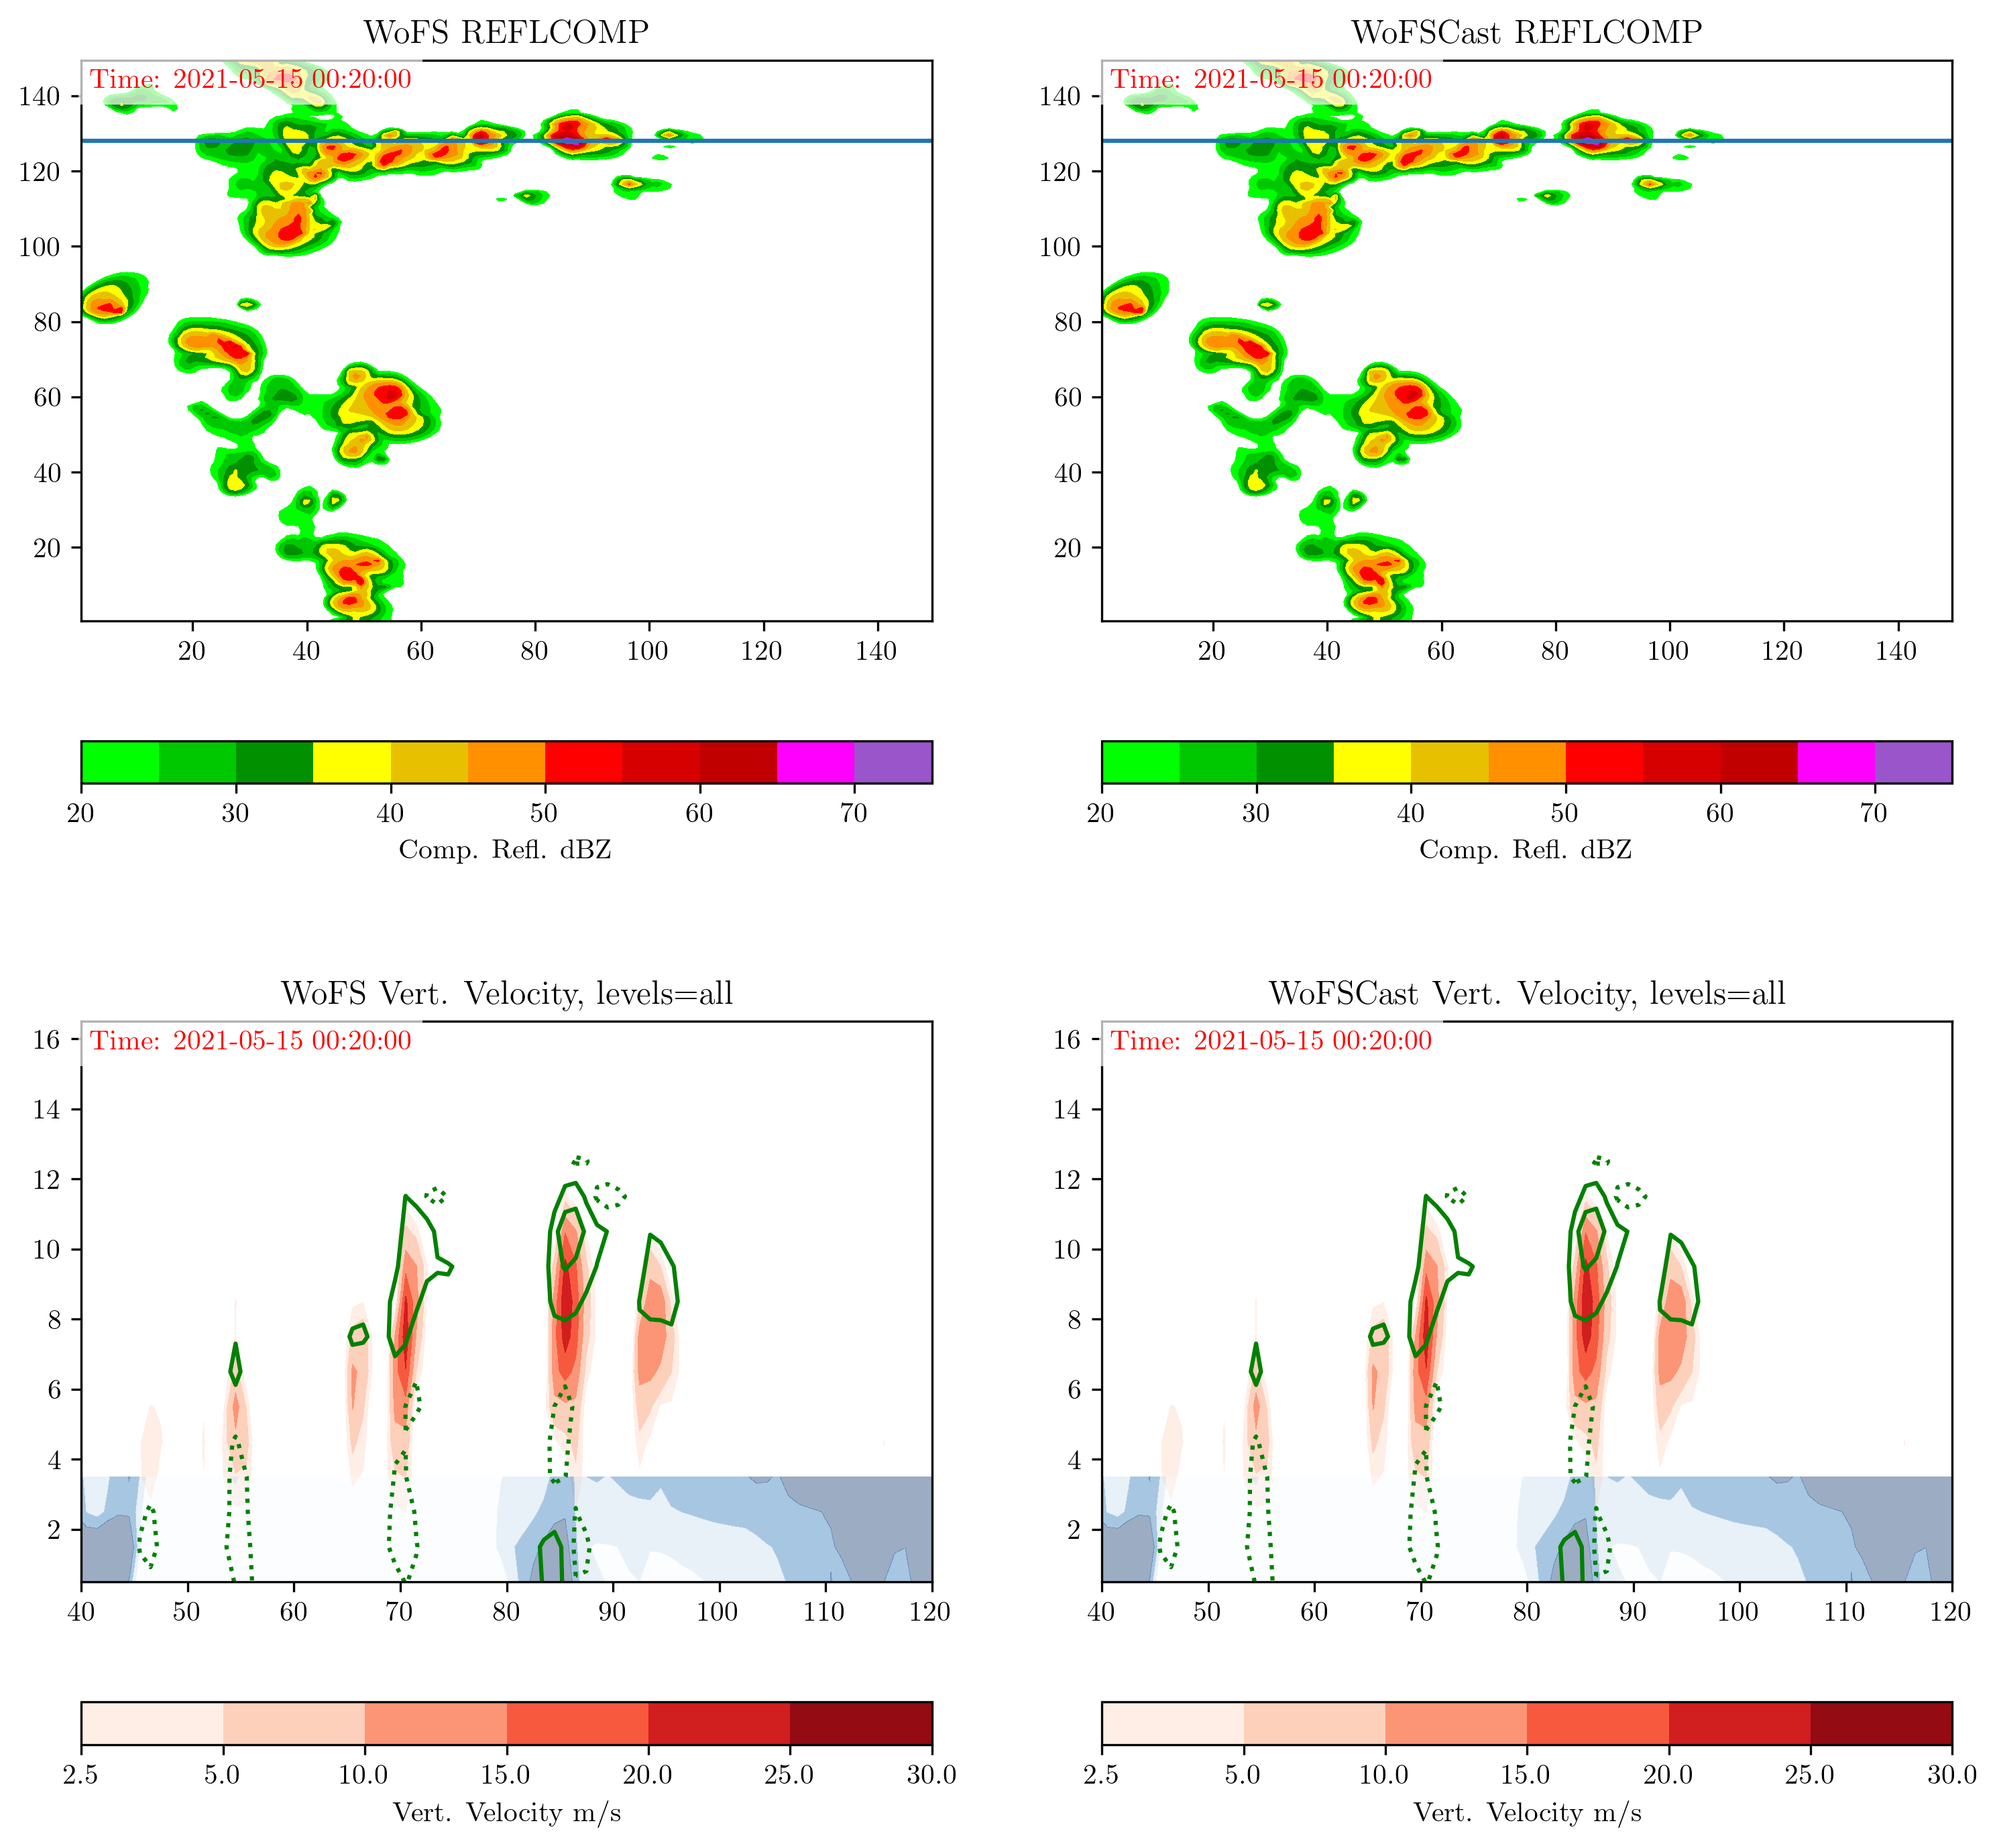

In [7]:
dts = to_datetimes(path, n_times = 14)

animator = WoFSCastAnimator(domain_size=150, dts=dts)
anim = animator(segments = 'auto', 
                var_list=['W', 'DIV', 'BUOY'],#, 'RAIN_AMOUNT'], 
                levels='all',
                inputs=inputs, 
                predictions=predictions, 
                targets=targets)

#anim.save(MODEL_PATH.replace('.npz', '_cross_sect.gif'), writer="pillow", fps=5) 
# To display the animation in a Jupyter notebook
#from IPython.display import HTML
#HTML(anim.to_jshtml())



In [8]:
predictions

<xarray.Dataset>
Dimensions:              (batch: 1, time: 12, lat: 150, lon: 150, level: 17)
Coordinates:
  * time                 (time) timedelta64[ns] 00:10:00 00:20:00 ... 02:00:00
  * lat                  (lat) float32 32.12 32.15 32.17 ... 36.14 36.17 36.19
  * level                (level) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * lon                  (lon) float32 79.53 79.56 79.59 ... 84.12 84.16 84.19
Dimensions without coordinates: batch
Data variables: (12/13)
    COMPOSITE_REFL_10CM  (batch, time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    GEOPOT               (batch, time, level, lat, lon) float32 1.393e+04 ......
    QVAPOR               (batch, time, level, lat, lon) float32 0.00679 ... 2...
    RAIN_AMOUNT          (batch, time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    T                    (batch, time, level, lat, lon) float32 307.2 ... 625.6
    T2                   (batch, time, lat, lon) float32 294.1 294.6 ... 289.0
    ...                   ...
    V                    (batch, time, level, lat, lon) float32 6.188 ... 5.825
    W                    (batch, time, level, lat, lon) float32 -0.02311 ... ...
    WMAX                 (batch, time, lat, lon) float32 0.15 0.2098 ... 0.274
    DIV                  (batch, time, level, lat, lon) float32 -0.0001689 .....
    RESID                (batch, time, level, lat, lon) float32 0.1182 ... 0.896
    BUOY                 (batch, time, level, lat, lon) float32 4.299 ... nan

In [10]:
(_, lat_y), _ = animator.find_max_mean_amplitude_cross_section(
    targets.isel(batch=0)['COMPOSITE_REFL_10CM'].values, t=6
)

lat_y

125

In [35]:
path = '/work2/wofs_zarr/2021/20210514/0000/ENS_MEM_01/wrfwof_d01_2021-05-15_00:00:00.zarr'
ds = xr.open_zarr(path)

grid_lat = ds.lat[75:-75].values
grid_lon = ds.lon[75:-75].values

In [42]:
grid_lon

array([-103.17444 , -103.14151 , -103.10858 , -103.07565 , -103.042725,
       -103.00983 , -102.97687 , -102.94394 , -102.91101 , -102.87808 ,
       -102.84515 , -102.812225, -102.7793  , -102.74634 , -102.71341 ,
       -102.68048 , -102.64755 , -102.614624, -102.581665, -102.54874 ,
       -102.51581 , -102.48285 , -102.44992 , -102.41696 , -102.38403 ,
       -102.351074, -102.318146, -102.28522 , -102.25226 , -102.2193  ,
       -102.18637 , -102.15344 , -102.12048 , -102.087524, -102.054596,
       -102.02164 , -101.98871 , -101.95575 , -101.92279 , -101.88983 ,
       -101.8569  , -101.823944, -101.791016, -101.75806 , -101.7251  ,
       -101.69214 , -101.65921 , -101.62625 , -101.59329 , -101.56033 ,
       -101.527405, -101.494446, -101.46149 , -101.42853 , -101.39557 ,
       -101.36261 , -101.32968 , -101.29672 , -101.26376 , -101.230804,
       -101.197845, -101.16492 , -101.13196 , -101.099   , -101.06604 ,
       -101.03308 , -101.00012 , -100.96716 , -100.934204, -100.

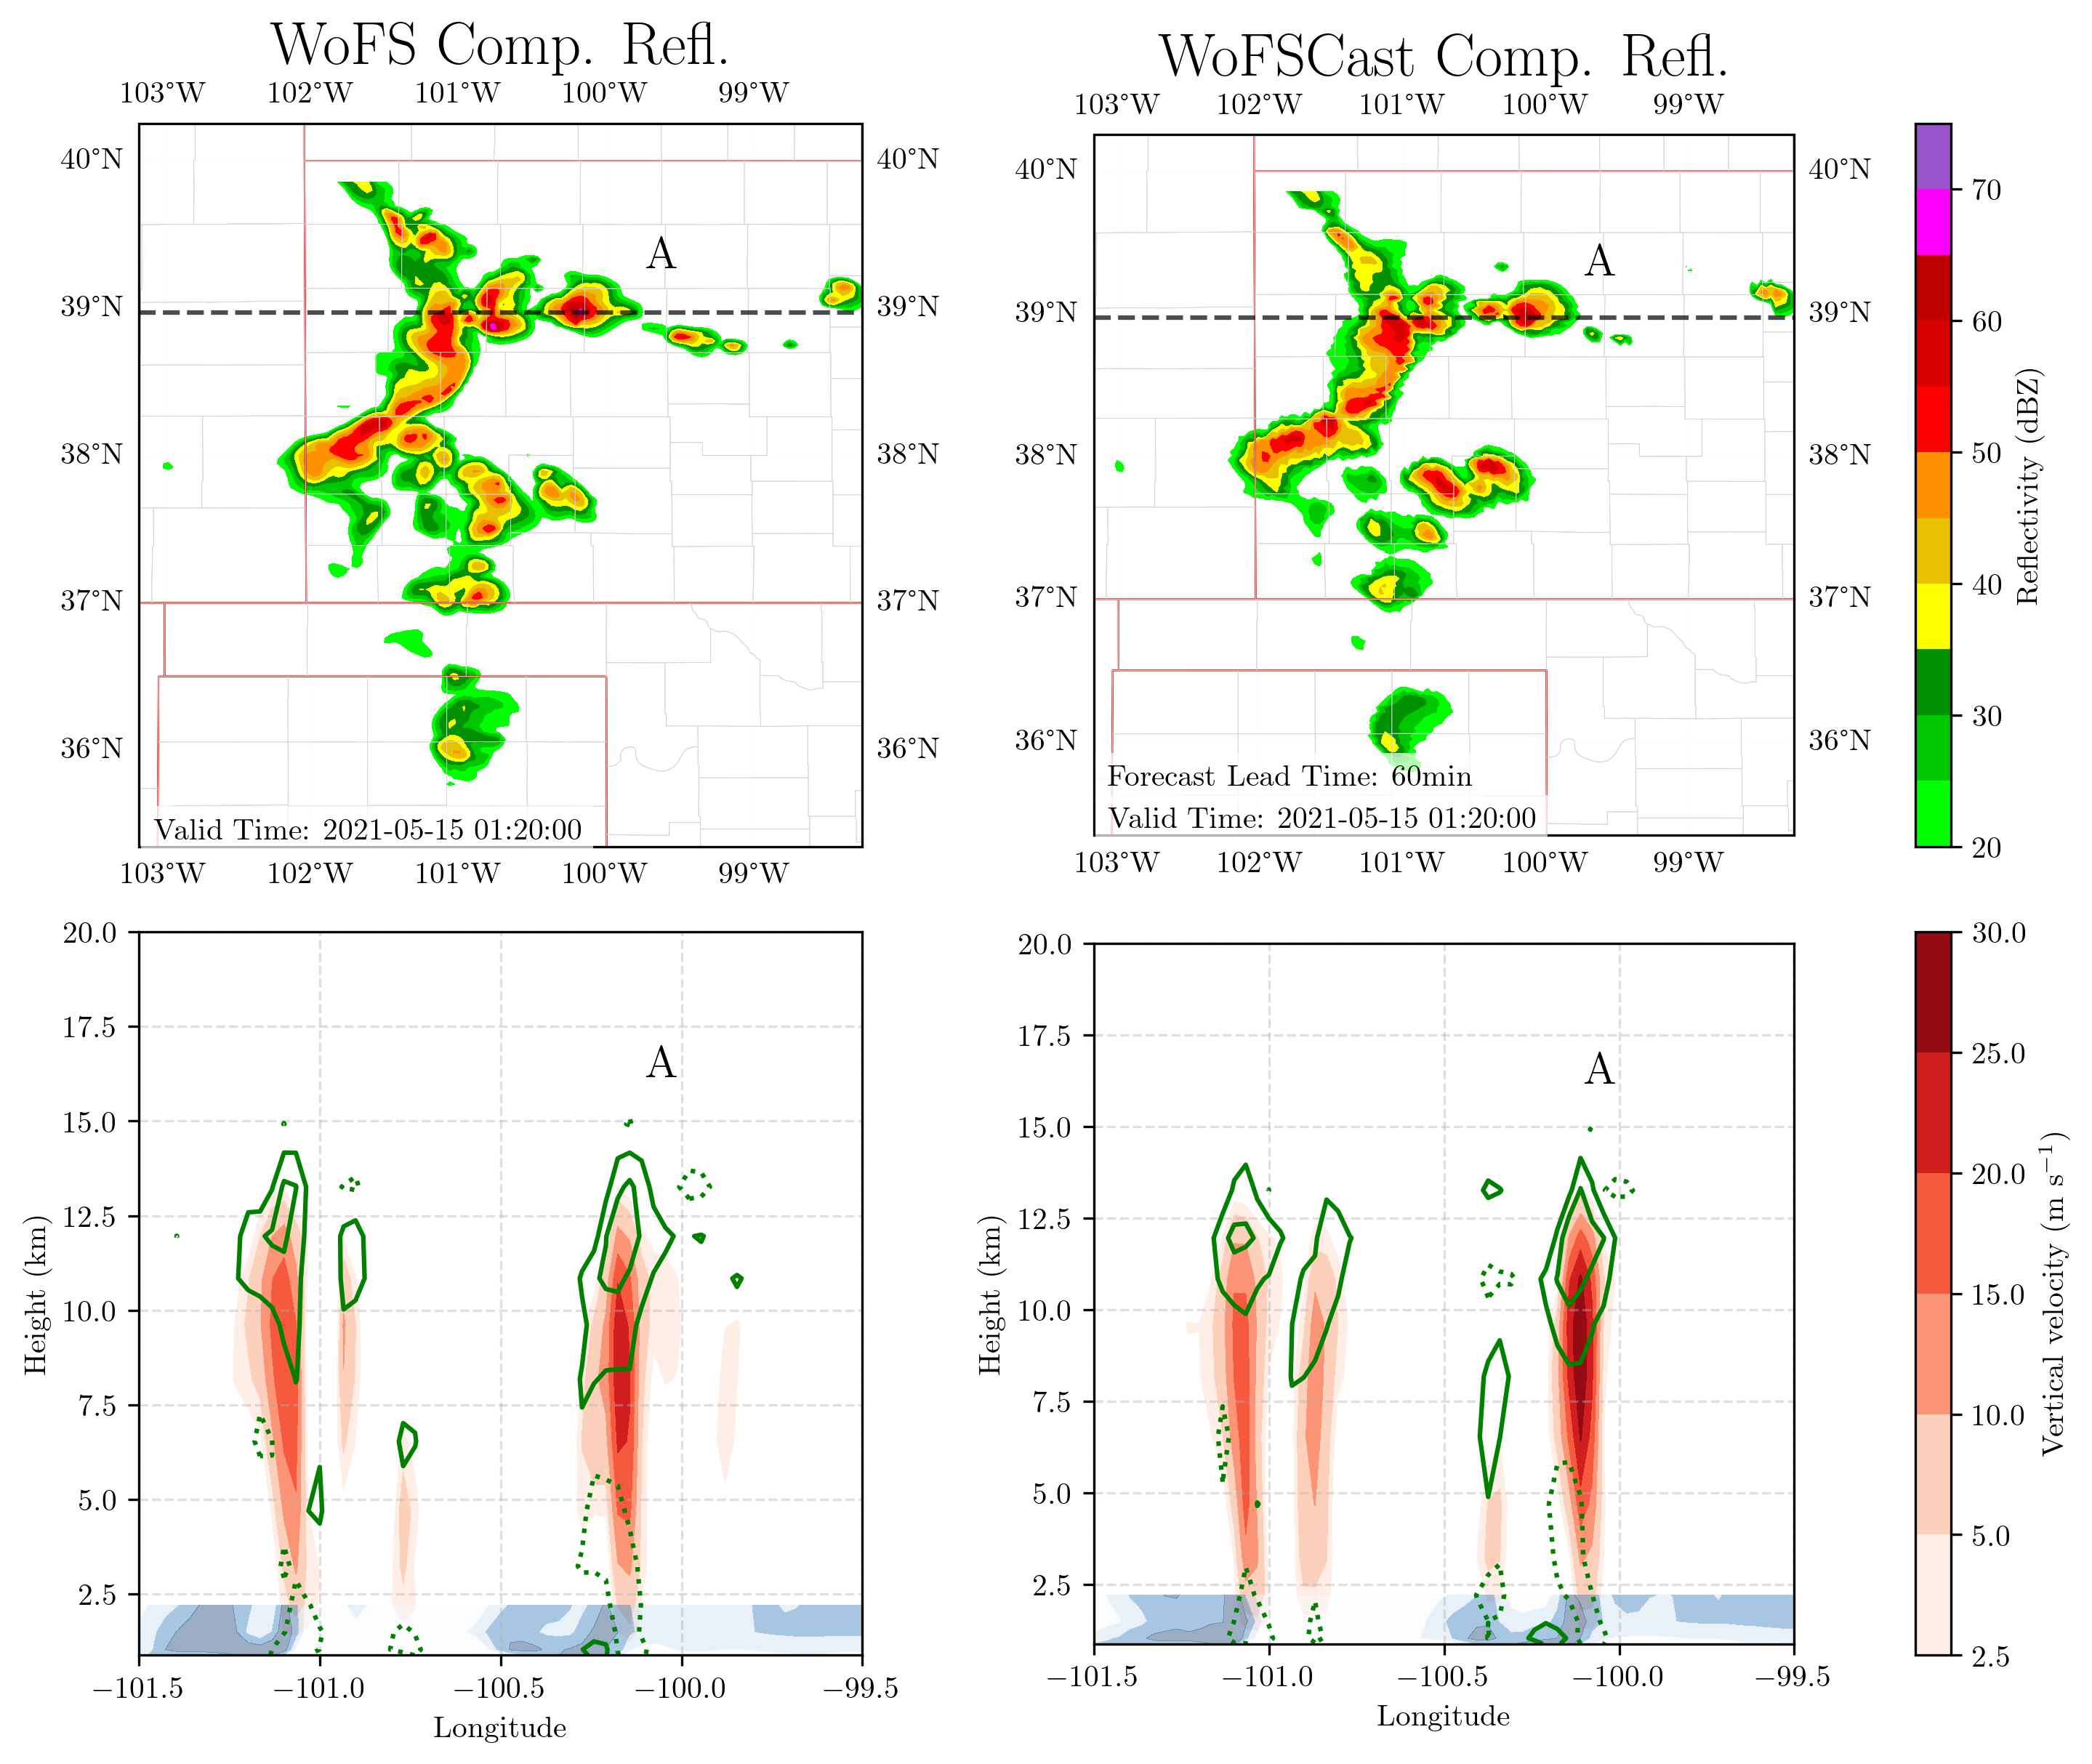

In [49]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# a single time to plot. 
t = 6
this_tar = targets.isel(batch=0, time=t) 
this_pred = predictions.isel(batch=0, time=t)

(_, lat_y), _ = animator.find_max_mean_amplitude_cross_section(
    targets.isel(batch=0)['COMPOSITE_REFL_10CM'].values, t
)

#print(lat_y)
lat_y=117

# Create the figure and the first row with Cartopy GeoAxes
fig = plt.figure(dpi=300, figsize=(10,8))

# Top-left panel: Latitude-Longitude Plot 1
ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
# Top-right panel: Latitude-Longitude Plot 2
ax2 = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
# Bottom-left panel: Vertical-Longitude Plot 1
ax3 = fig.add_subplot(2, 2, 3)
# Bottom-right panel: Vertical-Longitude Plot 2
ax4 = fig.add_subplot(2, 2, 4)

axes = [ax1, ax2, ax3, ax4]

# Adjust axes to ensure square aspect ratio
axes = [ax1, ax2, ax3, ax4]
for ax in axes:
    ax.set_box_aspect(1)  # Ensure square aspect ratio    
    
    
# Set projections for the latitude-longitude plots
proj = ccrs.PlateCarree()
#grid_lat = dataset['lat'].values
#grid_lon = dataset['lon'].values-180.

x,y = np.meshgrid(grid_lon, grid_lat)

extent = [np.min(grid_lon), np.max(grid_lon), np.min(grid_lat), np.max(grid_lat)]

titles = ['WoFS', 'WoFSCast']
zs = [this_tar, this_pred]

cmap = WoFSColors.nws_dz_cmap
levels = WoFSLevels.dz_levels_nws


# The top 2 panels are latitude-longitude plots of the composite refl.
for i, (ax, z) in enumerate(zip(axes[:2], zs)):

    # Add state boundaries
    states = cfeature.NaturalEarthFeature(category='cultural', scale='10m', 
                                      facecolor='none', name='admin_1_states_provinces')
    ax.add_feature(states, edgecolor='red', linewidth=0.5)

    # Add county boundaries
    counties = cfeature.NaturalEarthFeature(category='cultural', scale='10m',
                                        facecolor='none', name='admin_2_counties')
    
    ax.add_feature(counties, edgecolor='lightgray', linewidth=0.2)
    
    # Set the extent of the map to the region of interest
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    z_vals = z['COMPOSITE_REFL_10CM'].values
    z_vals = np.ma.masked_where(z_vals < 1, z_vals)
    
    cf = ax.contourf(x,y,z_vals, cmap=cmap, levels=levels)
    
    ax.axhline(y=grid_lat[lat_y], ls='dashed', color='k', alpha=0.7)
    ax.set_title(f'{titles[i]} Comp. Refl.', fontsize=20)
    
    # Add gridlines
    ax.gridlines(draw_labels=True, linewidth=0.01, color='gray', alpha=0.5, linestyle='--')

    ax.annotate(f'Valid Time: {dts[t]}', xy=(0.02, 0.01), xycoords='axes fraction', 
                    weight='bold', color='k', fontsize=10, 
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    if i > 0:
        ax.annotate('Forecast Lead Time: 60min', xy=(0.02, 0.07), xycoords='axes fraction', 
                    weight='bold', color='k', fontsize=10, 
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
   
    ax.annotate(f'A', xy= (0.7, 0.8), xycoords='axes fraction', fontsize=15)

# Add a single colorbar for the top two plots
cbar = fig.colorbar(cf, ax=ax2, orientation='vertical', pad=0.125)
cbar.set_label('Reflectivity (dBZ)')

hgt = np.round(predictions['GEOPOT'].isel(batch=0, time=0).mean(dim=['lat', 'lon']).values, 0) / 10000
    
# Bottom 2 panels are vertical-level--longitude plots for updraft, 
# cold pool temp, and divergence. 
for ax, z in zip(axes[2:], zs):
    
    z = z.transpose('lat', 'lon', 'level')
    
    #x,y = np.meshgrid(z.lon-180, z.level*3)
    x,y = np.meshgrid(grid_lon, hgt)
    
    im = ax.contourf(x,y, z.isel(lat=lat_y)['W'].values.T, origin='lower', 
                     aspect='equal', cmap='Reds', levels=[2.5, 5, 10, 15, 20, 25, 30])
    
    ax.contour(x, y, z.isel(lat=lat_y)['DIV'].values.T, levels = [-.01, -.003, -.001, .001, .003, .01], colors='green', 
                                   negative_linestyles='dotted',  aspect='equal')
    ax.contourf(x, y, z.isel(lat=lat_y)['BUOY'].values.T, aspect='equal', cmap='Blues_r', 
                                    levels=[-3, -2, -1], alpha=0.4, extend='both')

    #ax_twin = ax.twinx()
    #ax_twin.plot(grid_lon, z.isel(lat=lat_y)['RAIN_AMOUNT'].values.T)
    #ax_twin.set(ylim=[0,15], ylabel='Rain Rate (mm per 10 min)')
    
    ax.set(
           #ylabel='Vertical Level (WRF $\sigma$)', 
           ylabel = 'Height (km)', 
           xlabel = 'Longitude',
           xlim = [-101.5, -99.5], 
           ylim = [min(hgt), 20]
          )
    ax.grid(ls='dashed', alpha=0.4)
    ax.annotate(f'A', xy= (0.7, 0.8), xycoords='axes fraction', fontsize=15)
    
    # Set x-ticks to 5 evenly spaced values
    xticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 5)
    ax.set_xticks(xticks)
    

# Add a single colorbar for the top two plots
cbar = fig.colorbar(im, ax=ax4, orientation='vertical', pad=0.125)
cbar.set_label('Vertical velocity (m s$^{-1}$)')

plt.tight_layout()